# **Apple Leaf Disease Prediction**

Date: 25.02.2022

Version: 1.0

Author: Devashree Madhugiri



**Import all the Dependencies**

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

## **Plant village dataset: (Unaugmented version)**

https://data.mendeley.com/datasets/tywbtsjrjv/1


In [4]:
from pathlib import Path
image_dir = Path('../input/apple-leaves')

In [5]:
BATCH_SIZE = 20
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=10

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    seed=42,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 600 files belonging to 4 classes.


2022-02-27 19:54:16.149892: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
class_names = dataset.class_names
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy']

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

2022-02-27 19:54:24.680819: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(20, 224, 224, 3)
[2 3 2 0 0 2 3 1 2 0 0 0 1 3 0 0 0 3 1 1]


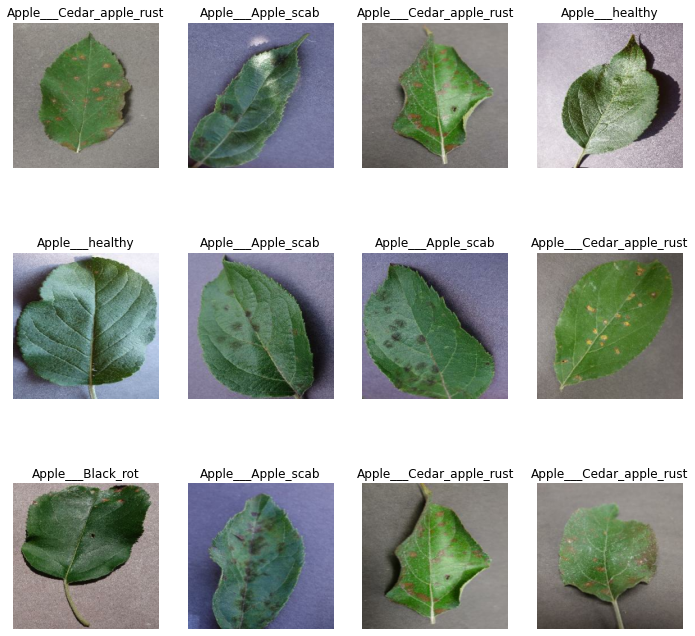

In [9]:
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=1234)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
len(train_ds)

24

In [13]:
len(val_ds)

3

In [14]:
len(test_ds)

3

**Cache, Shuffle, and Prefetch the Dataset**

In [15]:
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

# **Building the Model & Model Architecture**



In [16]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [17]:
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(64, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

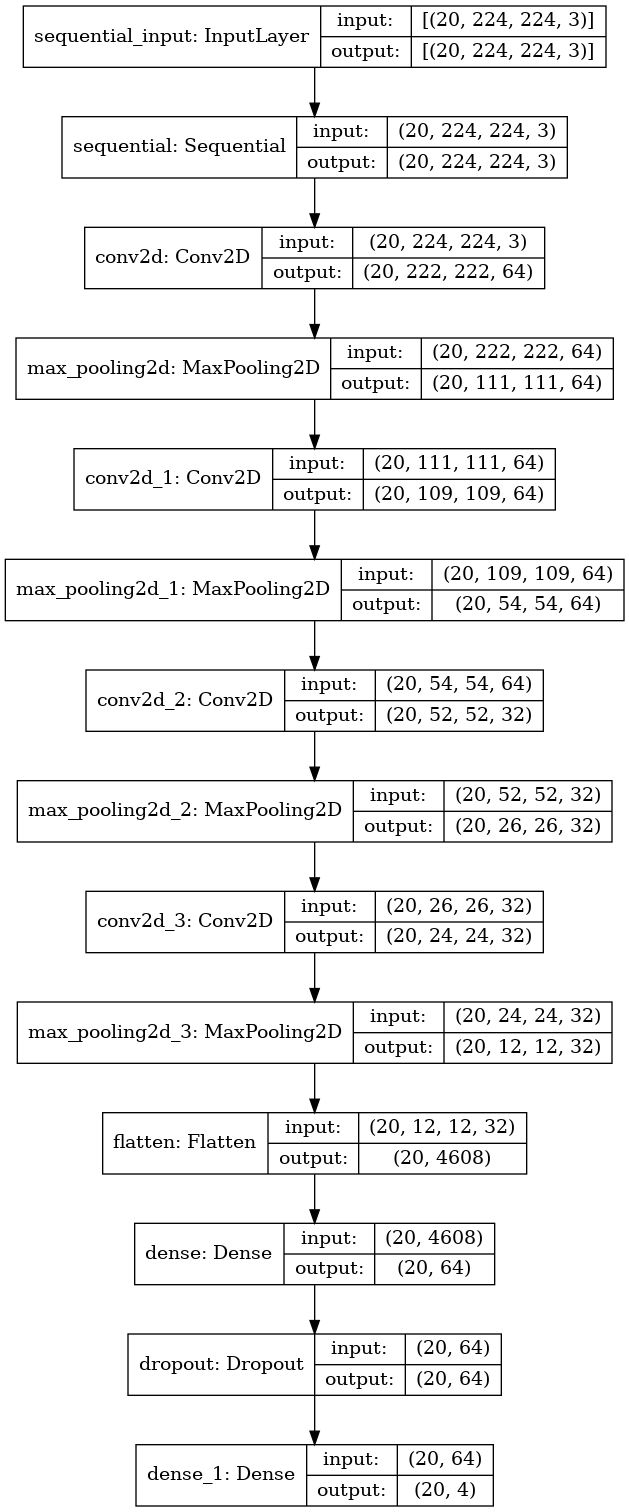

In [19]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (20, 224, 224, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (20, 222, 222, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (20, 111, 111, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (20, 109, 109, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (20, 54, 54, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (20, 52, 52, 32)          18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (20, 26, 26, 32)         

# **Compiling the Model**
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/10
24/24 [==============================] - 27s 1s/step - loss: 1.3970 - accuracy: 0.2917 - val_loss: 1.3790 - val_accuracy: 0.2000
Epoch 2/10
24/24 [==============================] - 24s 981ms/step - loss: 1.2972 - accuracy: 0.3771 - val_loss: 1.0299 - val_accuracy: 0.6167
Epoch 3/10
24/24 [==============================] - 24s 994ms/step - loss: 0.9098 - accuracy: 0.6396 - val_loss: 0.5209 - val_accuracy: 0.8333
Epoch 4/10
24/24 [==============================] - 24s 1s/step - loss: 0.7832 - accuracy: 0.7000 - val_loss: 0.5802 - val_accuracy: 0.7667
Epoch 5/10
24/24 [==============================] - 24s 1s/step - loss: 0.6529 - accuracy: 0.7792 - val_loss: 0.4160 - val_accuracy: 0.8667
Epoch 6/10
24/24 [==============================] - 24s 981ms/step - loss: 0.6141 - accuracy: 0.7750 - val_loss: 0.4083 - val_accuracy: 0.8833
Epoch 7/10
24/24 [==============================] - 24s 1s/step - loss: 0.4711 - accuracy: 0.8167 - val_loss: 0.4092 - val_accuracy: 0.8833
Epoch 8/10


In [23]:
scores = model.evaluate(test_ds)

3/3 [==============================] - 1s 249ms/step - loss: 0.1897 - accuracy: 0.9500


In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

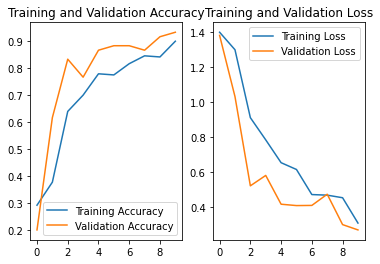

In [26]:
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Run prediction on a sample image**

first image to predict
actual label: Apple___Apple_scab
predicted label: Apple___Apple_scab


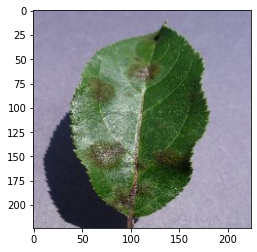

In [27]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# **Prediction function**

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# **Prediction on few sample images**

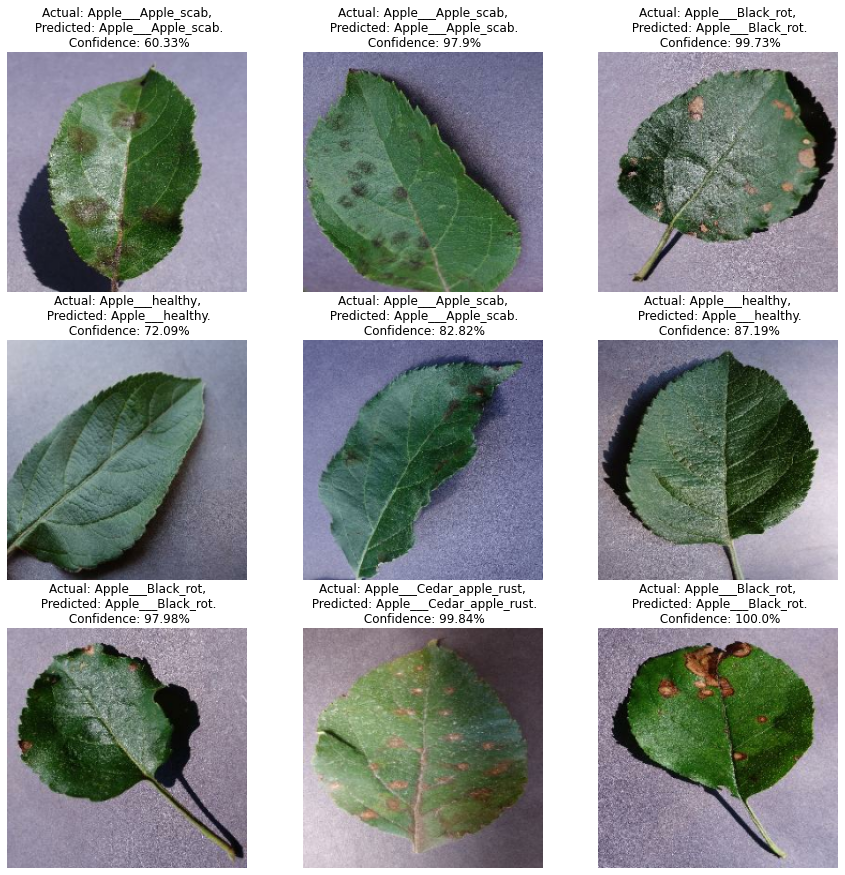

In [29]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# **Saving the Model**

In [30]:
model.save("apple_leaf_disease-prediction.h5")

In [31]:
pip install Augmentor

Note: you may need to restart the kernel to use updated packages.


In [35]:
#setting up an Augmentor pipeline

total_images=450*4
import Augmentor
# Passing the path of the image directory 
p = Augmentor.Pipeline(source_directory=image_dir,
                      output_directory="/kaggle/working/augmented")
  
# Defining augmentation parameters and generating samples

p.rotate90(probability=0.1)
p.flip_left_right(probability=0.4) 
p.flip_top_bottom(probability=0.8)
p.sample(total_images)

Initialised with 600 image(s) found.
Output directory set to /kaggle/working/augmented.

Processing <PIL.Image.Image image mode=RGB size=256x256 at 0x7F185C9D0110>: 100%|██████████| 1800/1800 [00:07<00:00, 256.43 Samples/s]                  


In [38]:
import os
#Counting number of Augmented Images
list1 = os.listdir("./augmented/Apple___Apple_scab")
list2 = os.listdir("./augmented/Apple___Black_rot")
list3 = os.listdir("./augmented/Apple___Cedar_apple_rust")
list4 = os.listdir("./augmented/Apple___healthy")
n1 = len(list1)
n2 = len(list2)
n3 = len(list3)
n4 = len(list4)

n=n1+n2+n3+n4
print ("Apple___Apple_scab:",n1,"\n""Apple___Black_rot:",n2,"\n""Apple___Cedar_apple_rust:",n3,"\n""Apple___healthy:",n4)
print ("Total Augmented images:",n)

Apple___Apple_scab: 412 
Apple___Black_rot: 484 
Apple___Cedar_apple_rust: 448 
Apple___healthy: 456
Total Augmented images: 1800


In [39]:
#update parameters
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=10

In [40]:
aug_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./augmented",
    seed=42,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1800 files belonging to 4 classes.


In [41]:
class_names = aug_dataset.class_names
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy']

In [42]:
for image_batch, labels_batch in aug_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[3 3 3 1 2 0 3 1 3 1 3 2 2 3 2 1 0 3 2 1 2 1 2 1 3 1 2 2 3 1 3 3]


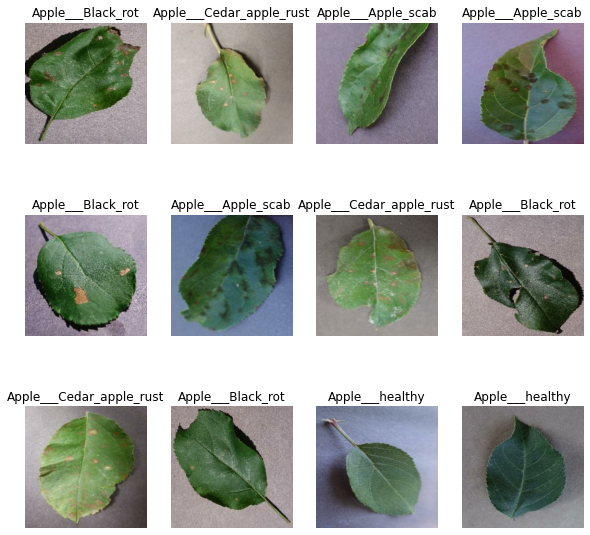

In [43]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in aug_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [44]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds=aug_dataset
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=1234)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [45]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(aug_dataset)

In [46]:
len(train_ds)

45

In [47]:
len(val_ds)

5

In [48]:
len(test_ds)

7

**Cache, Shuffle, and Prefetch the Dataset**

In [49]:
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

# **Load the saved Model and train on augmented dataset**

In [50]:
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [52]:
from tensorflow import keras
model_n = keras.models.load_model('./apple_leaf_disease-prediction.h5')

In [53]:
model_n.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [54]:
history_n = model_n.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/10
45/45 [==============================] - 75s 2s/step - loss: 0.8975 - accuracy: 0.6653 - val_loss: 0.6722 - val_accuracy: 0.7437
Epoch 2/10
45/45 [==============================] - 70s 2s/step - loss: 0.5948 - accuracy: 0.8023 - val_loss: 0.4638 - val_accuracy: 0.8250
Epoch 3/10
45/45 [==============================] - 70s 2s/step - loss: 0.4914 - accuracy: 0.8270 - val_loss: 0.6651 - val_accuracy: 0.7437
Epoch 4/10
45/45 [==============================] - 69s 2s/step - loss: 0.4613 - accuracy: 0.8355 - val_loss: 0.5273 - val_accuracy: 0.8062
Epoch 5/10
45/45 [==============================] - 70s 2s/step - loss: 0.3993 - accuracy: 0.8637 - val_loss: 0.3207 - val_accuracy: 0.9125
Epoch 6/10
45/45 [==============================] - 68s 2s/step - loss: 0.3985 - accuracy: 0.8595 - val_loss: 0.3622 - val_accuracy: 0.8500
Epoch 7/10
45/45 [==============================] - 69s 2s/step - loss: 0.4009 - accuracy: 0.8637 - val_loss: 0.2935 - val_accuracy: 0.8813
Epoch 8/10
45/45 [==

In [55]:
scores_n = model.evaluate(test_ds)

7/7 [==============================] - 4s 385ms/step - loss: 1.7565 - accuracy: 0.6384


In [56]:
acc_n = history_n.history['accuracy']
val_acc_n = history_n.history['val_accuracy']

loss_n = history_n.history['loss']
val_loss_n = history_n.history['val_loss']

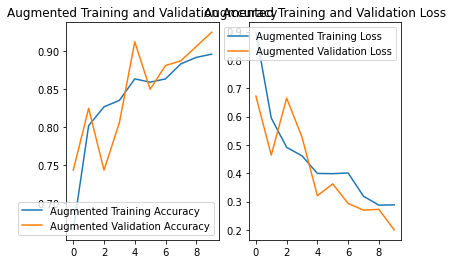

In [57]:
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc_n, label='Augmented Training Accuracy')
plt.plot(range(EPOCHS), val_acc_n, label='Augmented Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Augmented Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss_n, label='Augmented Training Loss')
plt.plot(range(EPOCHS), val_loss_n, label='Augmented Validation Loss')
plt.legend(loc='upper right')
plt.title('Augmented Training and Validation Loss')
plt.show()

# **Run prediction on a sample image**

first image to predict
actual label: Apple___Cedar_apple_rust
predicted label: Apple___Cedar_apple_rust


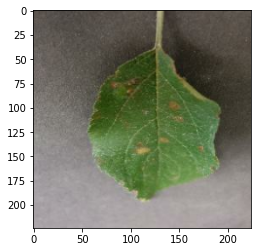

In [58]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [60]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

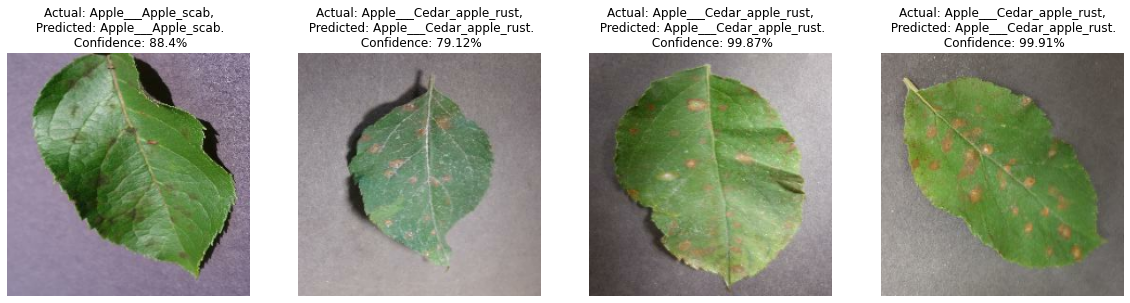

In [61]:
plt.figure(figsize=(20,10))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(1, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

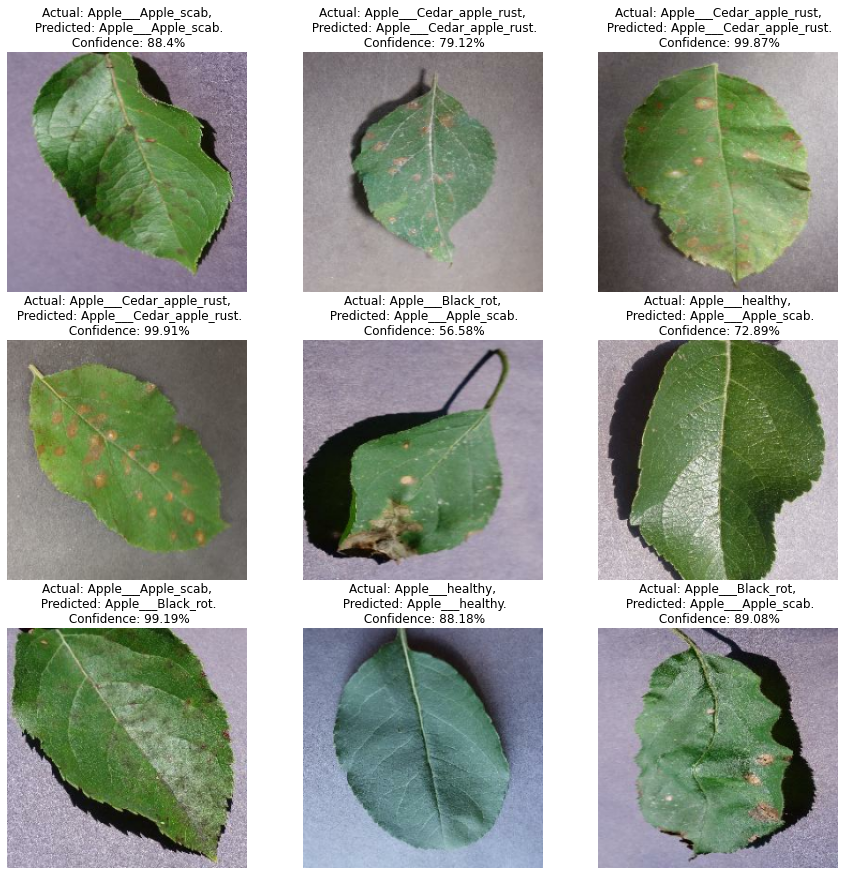

In [62]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# **Plotting accuracy and loss comparison on original dataset and augmented dataset**

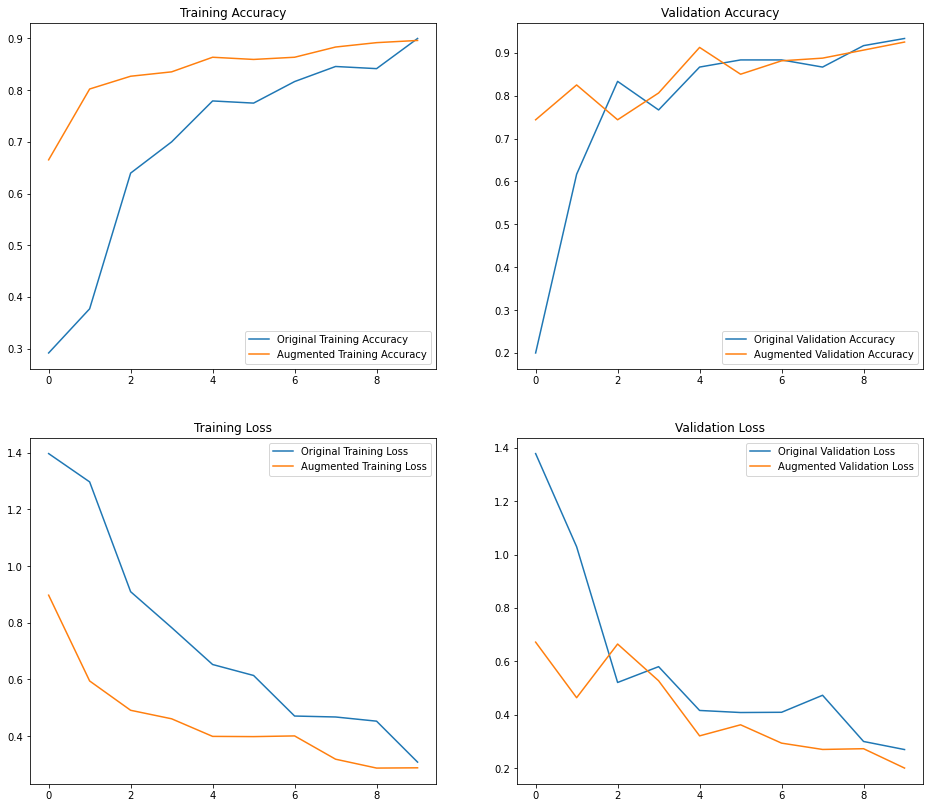

In [63]:
plt.figure(figsize=(16, 14))

plt.subplot(2, 2, 1)
plt.plot(range(EPOCHS), acc, label='Original Training Accuracy')
plt.plot(range(EPOCHS), acc_n, label='Augmented Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 2, 2)
plt.plot(range(EPOCHS), val_acc, label='Original Validation Accuracy')
plt.plot(range(EPOCHS), val_acc_n, label='Augmented Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

plt.subplot(2, 2, 3)
plt.plot(range(EPOCHS), loss, label='Original Training Loss')
plt.plot(range(EPOCHS), loss_n, label='Augmented Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')

plt.subplot(2, 2, 4)
plt.plot(range(EPOCHS), val_loss, label='Original Validation Loss')
plt.plot(range(EPOCHS), val_loss_n, label='Augmented Validation Loss')
plt.legend(loc='upper right')
plt.title('Validation Loss')
plt.show()